In [1]:
import os
from scripts.paper_figures.input import Input

import basty.project.experiment_processing as experiment_processing
from scripts.paper_figures.process_results import BehaviorData

from basty.utils import misc

In [2]:

RESULTS_FOLDER = r'Z:\mfk\basty-projects\backup-allHaltere\results\semisupervised_pair_kNN\predictions.100NN.neighbor_weights-distance.neighbor_weights_norm-count.activation-standard.voting-soft.voting_weights-None\exports'

BODY_PART_SETS = {"HaltereSwitch": "prob", "Feeding": "prob"}

CONFIG_PATH = r"Z:\mfk\basty-projects\main_cfg.yaml"

PROJECT_PATH = os.path.dirname(CONFIG_PATH)

TMP_RESULT_FOLDER = os.path.join(PROJECT_PATH,'tmp_results')

project = experiment_processing.Project(CONFIG_PATH)

BEHAVIORS = ['HaltereSwitch']

BODY_PART_SETS = {"ProboscisPumping": "prob", "Feeding": "prob", "HaltereSwitch": "halt"}

In [3]:
io_process = Input(project, RESULTS_FOLDER, TMP_RESULT_FOLDER)

In [4]:
expt_info_df = io_process.load_expt_info()
df_data = io_process.load_predictions()

In [5]:
# Drop Noise, Feeding, Grooming, ProboscisPumping from df_data
df_data.drop(['Noise','Feeding', 'Grooming', 'ProboscisPumping'], axis=1, inplace=True)

io_process.create_binary_masks_subfolders(BEHAVIORS)

In [6]:
llh = misc.get_likelihood(project.data_path_dict, CONFIG_PATH)

Loading existing llh_df.pickle file...


In [7]:
llh = llh[llh["ExptNames"].isin(df_data.ExptNames.unique())]

In [8]:
from importlib import reload
import scripts.paper_figures.process_results
reload(scripts.paper_figures.process_results)
from scripts.paper_figures.process_results import BehaviorData

process_data = BehaviorData(df_data, binary_mask_threshold=0.7,body_parts=BODY_PART_SETS['HaltereSwitch'])

process_data.process_expt_names_parallel(llh,io_process.get_binary_mask_subfolder(behavior='HaltereSwitch'))

File Fly05182022_5d_median6_threshold0.7.pkl already exists. Skipping calculation.File Fly05202022_5d_median6_threshold0.7.pkl already exists. Skipping calculation.
File Fly05252022_SD_5d_median6_threshold0.7.pkl already exists. Skipping calculation.
File Fly05222022_5d_median6_threshold0.7.pkl already exists. Skipping calculation.
File Fly05272022_SD_5d_median6_threshold0.7.pkl already exists. Skipping calculation.
File Fly06072022_5d_median6_threshold0.7.pkl already exists. Skipping calculation.
File Fly06142022_SD_5d_median6_threshold0.7.pkl already exists. Skipping calculation.
File Fly06082022_5d_median6_threshold0.7.pkl already exists. Skipping calculation.
File Fly06152022_6d_median6_threshold0.7.pkl already exists. Skipping calculation.
File Fly06182022_4d_median6_threshold0.7.pkl already exists. Skipping calculation.
File Fly06202022_5d_median6_threshold0.7.pkl already exists. Skipping calculation.
File Fly06212022_5d_median6_threshold0.7.pkl already exists. Skipping calculati

In [9]:
masks_based_on_llh = io_process.load_binary_mask('HaltereSwitch')
beh_masks = process_data.create_binary_mask_from_behaviors(BEHAVIORS,'HaltereSwitch')
masked_data = process_data.update_dictionary_with_final_masked(masks_based_on_llh,beh_masks)

In [10]:
# Remove all the haltere switch events that scored less than 0.5

# Masked data is a dictionary, so for each key, we have a dataframe get the column name that ends with _final_masked

for key in masked_data.keys():
    # Get the DataFrame associated with the current key
    df = masked_data[key]
    
    # Filter the column(s) of interest
    column_filtered = df.filter(regex='_final_masked$').columns[0]
    
    # Apply the transformation to the filtered column
    df[column_filtered] = df[column_filtered].apply(lambda x: x if x > 0.5 else 0)
    
    # Update the modified DataFrame back into the dictionary
    masked_data[key] = df



In [11]:
bouts_dict = BehaviorData.find_consecutive_bouts_and_snap_fts(masked_data, io_process, 'HaltereSwitch', 6, 30*5, 60, False)

Processing Experiments: 100%|██████████| 61/61 [00:03<00:00, 16.51it/s]


In [12]:
import pickle
folder_path = io_process.get_prediction_result_folder('HaltereSwitch')

if not bouts_dict:
    raise ValueError("Bouts are not processed")

with open(os.path.join(folder_path, 'bouts_dict.pkl'), 'wb') as f:
    pickle.dump(bouts_dict, f)

In [13]:
import pandas as pd

import pandas as pd

def find_largest_change(timeseries):
    # Convert the input list/array to a pandas Series
    timeseries = pd.Series(timeseries)
    
    # Compute the difference between consecutive points in the series
    diffs = timeseries.diff().abs()
    
    # Create a rolling window and find the maximum absolute difference
    rolling_max_diff = diffs.rolling(window=30).max()
    
    # Return the index of the largest change
    return rolling_max_diff.idxmax()

def filter_small_ranges(timeseries,value=4):
    """Returns True if the range of the timeseries is >= 4, otherwise False"""
    return (max(timeseries) - min(timeseries)) >= value

# Create an empty dictionary to store the results
index_of_max_changes = {}
mod_dict = {}

# Process each unique key in the bouts_dict
for key in bouts_dict:
    df = bouts_dict[key]
    
    # Filter rows where the timeseries range is less than 4 pixels
    df = df[df['distance.thor_post-halt'].apply(filter_small_ranges)]
    
    # Apply the find_largest_change function to each row of the 'distance.thor_post-halt' column
    indices = df['distance.thor_post-halt'].apply(find_largest_change)
    
    # Store the result in the index_of_max_changes dictionary
    index_of_max_changes[key] = indices
    
    mod_dict[key] = df

# Create an empty dictionary to store the final results
final_dataframes = {}

# Process each unique key in the bouts_dict
for key in mod_dict:
    df = mod_dict[key]
    
    # Create a new dataframe with start_index, stop_index, and index_of_max_changes
    result_df = pd.DataFrame({
        'start_index': df['start_index'].values + index_of_max_changes[key].values-15,
        'stop_index': df['start_index'].values + index_of_max_changes[key].values + 15,
        'index_of_max_changes': index_of_max_changes[key].values
    })
    
    # Store the result dataframe in the final_dataframes dictionary
    final_dataframes[key] = result_df

In [14]:
# Save the dataframe to disk 
import pickle
folder_path = io_process.get_prediction_result_folder('HaltereSwitch')

if not bouts_dict:
    raise ValueError("Bouts are not processed")

with open(os.path.join(folder_path, 'haltere_final.pkl'), 'wb') as f:
    pickle.dump(final_dataframes, f)

In [15]:
# Remove the following key from the final_dataframes 'Fly05252022_SD_5d
final_dataframes.pop('Fly05252022_SD_5d')

,start_index,stop_index,index_of_max_changes
0,139813,139843,857
1,194644,194674,234
2,196379,196409,30
3,208583,208613,327
4,209066,209096,266
5,221578,221608,177
6,233056,233086,615
7,234327,234357,201
8,234815,234845,128
9,237333,237363,336


In [16]:
result_list = []

for name, df in final_dataframes.items():
    df = df.copy()  # Make a copy of the dataframe to avoid modifying the original
    df['ExptNames'] = name
    result_list.append(df)

concatenated_df = pd.concat(result_list, ignore_index=True)



In [17]:
concatenated_df

,start_index,stop_index,index_of_max_changes,ExptNames
0,68907,68937,903,Fly06252022_5d_SD_A
1,218623,218653,2050,Fly06252022_5d_SD_A
2,236105,236135,186,Fly06252022_5d_SD_A
3,312164,312194,44,Fly06252022_5d_SD_A
4,350368,350398,129,Fly06252022_5d_SD_A
...,...,...,...,...
2241,1666207,1666237,52,Fly06182022_4d
2242,1673851,1673881,2585,Fly06182022_4d
2243,1674857,1674887,374,Fly06182022_4d
2244,1689534,1689564,7485,Fly06182022_4d


In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

# Plot haltere switch events
name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))

# 


In [18]:
name_to_sd = dict(zip(expt_info_df['ExptNames'], expt_info_df['SD']))
name_to_sex = dict(zip(expt_info_df['ExptNames'], expt_info_df['Sex']))


# Possible values for sd and sex
sd_values = [False, True]
sex_values = ['M', 'F']

grouped_dict = {}

# Initialize an empty dictionary for each group
for sd_value in sd_values:
    for sex_value in sex_values:
        grouped_name = f'SD_{sd_value}_Sex_{sex_value}'
        grouped_dict[grouped_name] = {}

# Loop over each key in final_dataframe to segregate it into one of the 4 groups
for key in final_dataframes.keys():
    sd = name_to_sd.get(key)
    sex = name_to_sex.get(key)
    
    grouped_name = f'SD_{sd}_Sex_{sex}'
    grouped_dict[grouped_name][key] = final_dataframes[key]

In [19]:
import numpy as np
def plot_data(group_dict, color='#d62728',sd=False,sex='F',behavior='Haltere_Switch',fig_path = r'C:\Users\Grover\Documents\GitHub\deepsleepfigs\Fig_4_5'):
    target_dict_name = f'SD_{sd}_Sex_{sex}'
    data_dict = group_dict[target_dict_name]
    
    fig, ax = plt.subplots(figsize=(15, len(data_dict) / 4))
    unique_names = list(data_dict.keys())

    for idx, name in enumerate(unique_names):
        subset_df = data_dict[name]
        subset_df['start_index_hr'] = subset_df['start_index'] / (30*60*60)
        subset_df['stop_index_hr'] = subset_df['stop_index'] / (30*60*60)
        
        for _, row in subset_df.iterrows():
            start_pos = row['start_index_hr']
            width = row['stop_index_hr'] - start_pos
            ax.barh(idx, width, left=start_pos, color=color, edgecolor='none')
            
    ax.set_yticks(range(len(unique_names)))
    ax.set_yticklabels(unique_names)
    # Set xticks to be in hours
    if sd:
        ax.set_xticks(np.arange(0, 7, 1))
        ax.set_xticklabels( [tick % 24 for tick in np.arange(0, 7,1)])
    else:
        ax.set_xticks(np.arange(0, 17,2))
        ax.set_xticklabels( [tick % 24 for tick in np.arange(10, 27,2)])
    
    # Add a title
    plt.title(target_dict_name)
    plt.xlim(0,16)
    
    plt.tight_layout()
    # Save the figure to disk
    plt.savefig(os.path.join(fig_path,f'{target_dict_name}_{behavior}_greater_than_4.pdf'))
    
    plt.show()


[2023-10-30 00:16:57] INFO - maxp pruned
[2023-10-30 00:16:57] INFO - LTSH dropped
[2023-10-30 00:16:57] INFO - cmap pruned
[2023-10-30 00:16:57] INFO - kern dropped
[2023-10-30 00:16:57] INFO - post pruned
[2023-10-30 00:16:57] INFO - PCLT dropped
[2023-10-30 00:16:57] INFO - JSTF dropped
[2023-10-30 00:16:57] INFO - meta dropped
[2023-10-30 00:16:57] INFO - DSIG dropped
[2023-10-30 00:16:57] INFO - GPOS pruned
[2023-10-30 00:16:57] INFO - GSUB pruned
[2023-10-30 00:16:57] INFO - glyf pruned
[2023-10-30 00:16:57] INFO - Added gid0 to subset
[2023-10-30 00:16:57] INFO - Added first four glyphs to subset
[2023-10-30 00:16:57] INFO - Closing glyph list over 'GSUB': 25 glyphs before
[2023-10-30 00:16:57] INFO - Glyph names: ['.notdef', 'A', 'B', 'D', 'F', 'S', 'a', 'd', 'e', 'eight', 'five', 'four', 'glyph00001', 'glyph00002', 'l', 'one', 's', 'seven', 'six', 'space', 'two', 'underscore', 'x', 'y', 'zero']
[2023-10-30 00:16:57] INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 23, 24, 25, 26, 

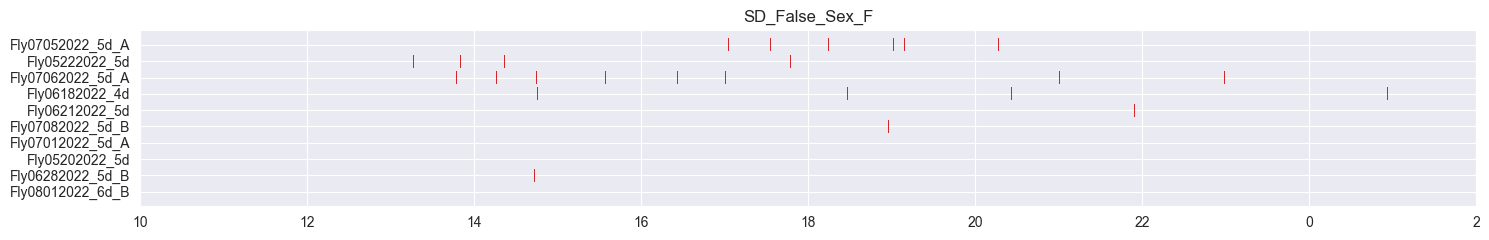

In [26]:
plot_data(grouped_dict,sd=False,sex='F',behavior='Haltere_Switch')

In [20]:
import numpy as np
# Initialize an empty dictionary to store the final results
grouped_binned = {}

# Process each key-value pair in the grouped_dict
for key, value_dict in grouped_dict.items():
    tmp_results = []
    
    for name, df in value_dict.items():
        df = df.copy()  # Make a copy of the dataframe to avoid modifying the original
        df['ExptNames'] = name
        tmp_results.append(df)

    # Concatenate the dataframes in the result_list
    binned_df = pd.concat(tmp_results, ignore_index=True)
    
    # Add a 'bin' column to the concatenated_df using the 'start_index' column
    binned_df['bin'] = pd.cut(binned_df['start_index'], bins=np.arange(0, 17*60*60*30, 30*60*60*1))
    
    # Store the resulting dataframe in the grouped_binned dictionary
    grouped_binned[key] = binned_df


In [25]:
grouped_binned['SD_False_Sex_F']

,start_index,stop_index,index_of_max_changes,ExptNames,bin
0,3354,3384,390,Fly08012022_6d_B,"(0, 108000]"
1,6308,6338,222,Fly08012022_6d_B,"(0, 108000]"
2,21134,21164,313,Fly08012022_6d_B,"(0, 108000]"
3,22671,22701,129,Fly08012022_6d_B,"(0, 108000]"
4,38488,38518,219,Fly08012022_6d_B,"(0, 108000]"
...,...,...,...,...,...
1024,1346498,1346528,712,Fly07052022_5d_A,"(1296000, 1404000]"
1025,1347917,1347947,221,Fly07052022_5d_A,"(1296000, 1404000]"
1026,1353027,1353057,270,Fly07052022_5d_A,"(1296000, 1404000]"
1027,1356992,1357022,435,Fly07052022_5d_A,"(1296000, 1404000]"


In [ ]:
def adjust_interval(interval):
    # Adjust the start and end of the interval
    start = interval.left / (30 * 60 * 60)
    end = interval.right / (30 * 60 * 60)
    
    # Return the new interval
    return pd.Interval(start, end)


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

def plot_binned_data(group_dict, sd=False,sex='F',behavior='Haltere_Switch',ylim_val = None,fig_path = r'C:\Users\Grover\Documents\GitHub\deepsleepfigs\Fig_4_5'):
    target_dict_name = f'SD_{sd}_Sex_{sex}'
    data_df = group_dict[target_dict_name]
    
    count_per_bin_per_experiment = data_df.groupby(['ExptNames', 'bin']).size().reset_index(name='Count')
    
    import seaborn as sns
    # Plot
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=count_per_bin_per_experiment, x='bin', y='Count', showfliers=False, color="skyblue",width=0.5, notch=False, boxprops=dict(edgecolor='none'),showcaps=False, whiskerprops={'visible': False})
    
    
    # Calculate the median values for each time bin
    medians = count_per_bin_per_experiment.groupby('bin')['Count'].median().reset_index()
    
    # Plot the medians using the mid_points for the x-axis
    plt.plot(range(len(medians)), medians['Count'], color='black', linestyle='-', marker='o', label="Median")


    plt.title("Boxplot of Counts per Bin for Each Experiment")


    if sd:
        xticklabels = [f'{x%24} - {(x+1)%24}' for x in np.arange(0, 6, 1)]
        plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels)
        plt.xlabel("Time (ZT)")
    else:
        xticklabels = [f'{x%24} - {(x+1)%24}' for x in np.arange(10, 26, 1)]
        plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels)
        plt.xlabel("Time (ZT)")

    plt.xlabel("ZT Time")
    
    if ylim_val is not None:
        plt.ylim(ylim_val)

    plt.tight_layout()
    # Save the figure to disk
    plt.savefig(os.path.join(fig_path,f'{target_dict_name}_{behavior}_binned_greater_than_5.pdf'))
    
    plt.show()


In [ ]:
plot_binned_data(grouped_binned,sd=True,sex='F',behavior='Haltere_Switch',ylim_val=None)


In [ ]:
# Save the dataframe to disk
import pickle
folder_path = io_process.get_prediction_result_folder('HaltereSwitch')


# Save grouped_dict and grouped_binned to disk
with open(os.path.join(folder_path, 'grouped_dict.pkl'), 'wb') as f:
    pickle.dump(grouped_dict, f)
    
with open(os.path.join(folder_path, 'grouped_binned.pkl'), 'wb') as f:
    pickle.dump(grouped_binned, f)



In [ ]:
import plotter
ploting = plotter.Plotter()

ploting.plot_time_series(bouts_dict,'distance.thor_post-halt','multipage_haltere_switch.pdf')

In [33]:
import pandas as pd
path = r'Z:\mfk\basty-projects\tmp_results\predictions\HaltereSwitch\grouped_binned.pkl'

#grouped_binned = pd.read_pickle(path)

In [37]:
sd_true_sex_f = grouped_binned['SD_True_Sex_F']
count_per_bin_per_experiment = sd_true_sex_f.groupby(['ExptNames', 'bin']).size().reset_index(name='Count')
sd=True
if sd:
    #remove bins larger than 30*60*60*6
    count_per_bin_per_experiment = count_per_bin_per_experiment[count_per_bin_per_experiment['bin'].apply(lambda x: x.left < 30*60*60*6)]
else:
    #remove bins larger than 30*60*60*16
    count_per_bin_per_experiment = count_per_bin_per_experiment[count_per_bin_per_experiment['bin'].apply(lambda x: x.left < 30*60*60*16)]
    

# Group by 'ExptNames' and grab the last two rows
last_two_bins = count_per_bin_per_experiment.groupby('ExptNames').apply(lambda group: group.head(2))

last_two_bins.reset_index(drop=True, inplace=True)

# Sum the counts for these rows
combined_counts = last_two_bins.groupby('ExptNames').agg({"Count": "sum"}).reset_index()


combined_counts['bin'] = 'Last 2 Bins Combined'  # Naming the bin column for clarity
first_2_hours_sd_true_sex_f = combined_counts

In [38]:
sd_false_sex_f = grouped_binned['SD_False_Sex_F']
count_per_bin_per_experiment = sd_false_sex_f.groupby(['ExptNames', 'bin']).size().reset_index(name='Count')
sd=False
if sd:
    #remove bins larger than 30*60*60*6
    count_per_bin_per_experiment = count_per_bin_per_experiment[count_per_bin_per_experiment['bin'].apply(lambda x: x.left < 30*60*60*6)]
    

# Group by 'ExptNames' and grab the last two rows
last_two_bins = count_per_bin_per_experiment.groupby('ExptNames').apply(lambda group: group.tail(2))

last_two_bins.reset_index(drop=True, inplace=True)

# Sum the counts for these rows
combined_counts = last_two_bins.groupby('ExptNames').agg({"Count": "sum"}).reset_index()


combined_counts['bin'] = 'Last 2 Bins Combined'  # Naming the bin column for clarity
last_2_hours_sd_false_sex_f= combined_counts

[2023-10-30 00:59:35] INFO - maxp pruned
[2023-10-30 00:59:35] INFO - LTSH dropped
[2023-10-30 00:59:35] INFO - cmap pruned
[2023-10-30 00:59:35] INFO - kern dropped
[2023-10-30 00:59:35] INFO - post pruned
[2023-10-30 00:59:35] INFO - PCLT dropped
[2023-10-30 00:59:35] INFO - JSTF dropped
[2023-10-30 00:59:35] INFO - meta dropped
[2023-10-30 00:59:35] INFO - DSIG dropped
[2023-10-30 00:59:35] INFO - GPOS pruned
[2023-10-30 00:59:35] INFO - GSUB pruned
[2023-10-30 00:59:35] INFO - glyf pruned
[2023-10-30 00:59:35] INFO - Added gid0 to subset
[2023-10-30 00:59:35] INFO - Added first four glyphs to subset
[2023-10-30 00:59:35] INFO - Closing glyph list over 'GSUB': 28 glyphs before
[2023-10-30 00:59:35] INFO - Glyph names: ['.notdef', 'C', 'D', 'F', 'S', 'a', 'b', 'c', 'd', 'e', 'f', 'five', 'glyph00001', 'glyph00002', 'i', 'm', 'n', 'o', 'one', 'p', 'r', 's', 'space', 't', 'two', 'u', 'w', 'zero']
[2023-10-30 00:59:35] INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 24, 38, 39, 41, 54, 68,

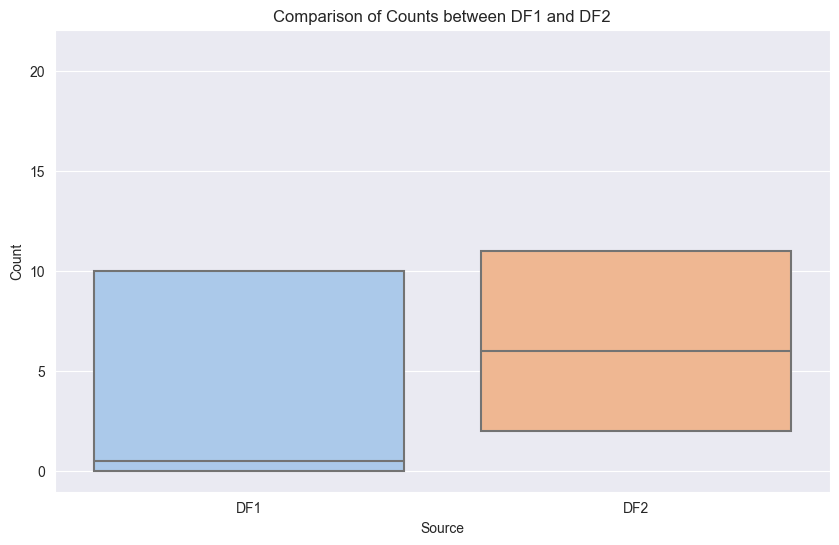

In [45]:

import pandas as pd

last_2_hours_sd_false_sex_f['Source'] = 'DF1'
first_2_hours_sd_true_sex_f['Source'] = 'DF2'

combined_df = pd.concat([last_2_hours_sd_false_sex_f, first_2_hours_sd_true_sex_f], ignore_index=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='Source', y='Count', palette="pastel", showfliers=False,showcaps=False, whiskerprops={'visible': False})
plt.title('Comparison of Counts between DF1 and DF2')
# Save the figure
plt.savefig('boxplot_comparison_haltere_last_two_hours_female.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [32]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(last_2_hours_sd_false_sex_f['Count'], first_2_hours_sd_true_sex_f['Count'])
print(f"Statistic: {statistic}, P-value: {p_value}")






Statistic: 44.5, P-value: 0.20774416772696913


In [34]:
sd_true_sex_m = grouped_binned['SD_True_Sex_M']
count_per_bin_per_experiment = sd_true_sex_m.groupby(['ExptNames', 'bin']).size().reset_index(name='Count')
sd = True
if sd:
    #remove bins larger than 30*60*60*6
    count_per_bin_per_experiment = count_per_bin_per_experiment[
        count_per_bin_per_experiment['bin'].apply(lambda x: x.left < 30 * 60 * 60 * 6)]
else:
    #remove bins larger than 30*60*60*16
    count_per_bin_per_experiment = count_per_bin_per_experiment[
        count_per_bin_per_experiment['bin'].apply(lambda x: x.left < 30 * 60 * 60 * 16)]

# Group by 'ExptNames' and grab the last two rows
last_two_bins = count_per_bin_per_experiment.groupby('ExptNames').apply(lambda group: group.head(2))

last_two_bins.reset_index(drop=True, inplace=True)

# Sum the counts for these rows
combined_counts = last_two_bins.groupby('ExptNames').agg({"Count": "sum"}).reset_index()

combined_counts['bin'] = 'Last 2 Bins Combined'  # Naming the bin column for clarity
first_2_hours_sd_true_sex_m = combined_counts
sd_false_sex_m = grouped_binned['SD_False_Sex_M']
count_per_bin_per_experiment = sd_false_sex_m.groupby(['ExptNames', 'bin']).size().reset_index(name='Count')
sd = False
if sd:
    #remove bins larger than 30*60*60*6
    count_per_bin_per_experiment = count_per_bin_per_experiment[
        count_per_bin_per_experiment['bin'].apply(lambda x: x.left < 30 * 60 * 60 * 6)]

# Group by 'ExptNames' and grab the last two rows
last_two_bins = count_per_bin_per_experiment.groupby('ExptNames').apply(lambda group: group.tail(2))

last_two_bins.reset_index(drop=True, inplace=True)

# Sum the counts for these rows
combined_counts = last_two_bins.groupby('ExptNames').agg({"Count": "sum"}).reset_index()

combined_counts['bin'] = 'Last 2 Bins Combined'  # Naming the bin column for clarity
last_2_hours_sd_false_sex_m = combined_counts

[2023-10-30 00:36:09] INFO - maxp pruned
[2023-10-30 00:36:09] INFO - LTSH dropped
[2023-10-30 00:36:09] INFO - cmap pruned
[2023-10-30 00:36:09] INFO - kern dropped
[2023-10-30 00:36:09] INFO - post pruned
[2023-10-30 00:36:09] INFO - PCLT dropped
[2023-10-30 00:36:09] INFO - JSTF dropped
[2023-10-30 00:36:09] INFO - meta dropped
[2023-10-30 00:36:09] INFO - DSIG dropped
[2023-10-30 00:36:09] INFO - GPOS pruned
[2023-10-30 00:36:09] INFO - GSUB pruned
[2023-10-30 00:36:09] INFO - glyf pruned
[2023-10-30 00:36:09] INFO - Added gid0 to subset
[2023-10-30 00:36:09] INFO - Added first four glyphs to subset
[2023-10-30 00:36:09] INFO - Closing glyph list over 'GSUB': 30 glyphs before
[2023-10-30 00:36:09] INFO - Glyph names: ['.notdef', 'C', 'D', 'F', 'S', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'four', 'glyph00001', 'glyph00002', 'i', 'm', 'n', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'two', 'u', 'w', 'zero']
[2023-10-30 00:36:09] INFO - Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 23, 25,

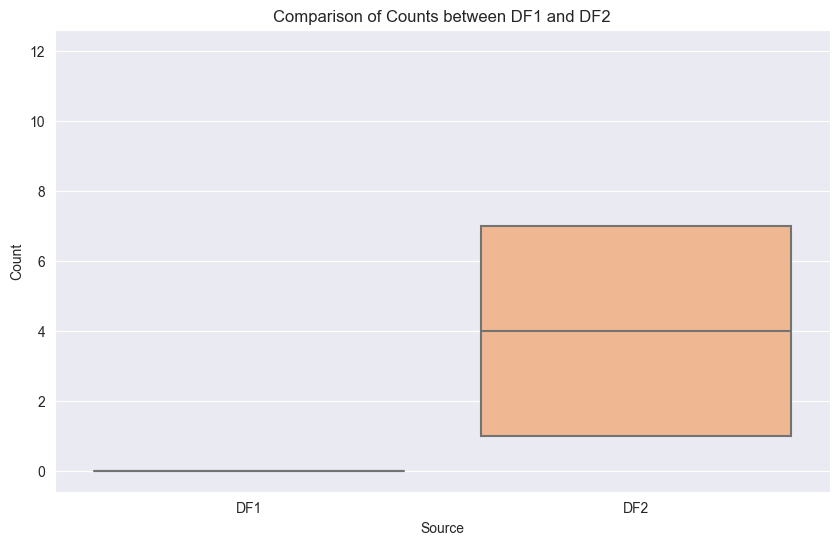

In [43]:
import pandas as pd

last_2_hours_sd_false_sex_m['Source'] = 'DF1'
first_2_hours_sd_true_sex_m['Source'] = 'DF2'

combined_df = pd.concat([last_2_hours_sd_false_sex_m, first_2_hours_sd_true_sex_m], ignore_index=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='Source', y='Count', palette="pastel", showfliers=False,showcaps=False, whiskerprops={'visible': False})
plt.title('Comparison of Counts between DF1 and DF2')
# Save the figure
plt.savefig('boxplot_comparison_haltere_last_two_hours_male.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [41]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(last_2_hours_sd_false_sex_m['Count'], first_2_hours_sd_true_sex_m['Count'])
print(f"Statistic: {statistic}, P-value: {p_value}")





Statistic: 9.0, P-value: 2.2553684686052665e-07


In [42]:
p_value<0.001

True